<a href="https://colab.research.google.com/github/Srishtiv2001/capstone/blob/codes/Classical_code_GPU(4_cities)_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from pylab import rcParams

In [ ]:
plt.style.use('dark_background')
rcParams['figure.figsize'] = 16, 10

In [ ]:
np.random.seed(18)

size, cmin, cmax = 4, -100, 100
data = pd.DataFrame(dict(x=[0], y=[0])).append(
    pd.DataFrame((np.random.random_sample(2*size)*(cmax-cmin)+cmin).reshape(-1,2), columns=['x', 'y']), ignore_index=True)
data

<ipython-input-3-68cd60519fce>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = pd.DataFrame(dict(x=[0], y=[0])).append(


,x,y
0,0.000000,0.000000
1,30.074848,1.090675
2,75.720294,-63.631955
3,70.446614,50.027257
4,33.220333,97.579090


In [ ]:
data2=data.values.tolist()

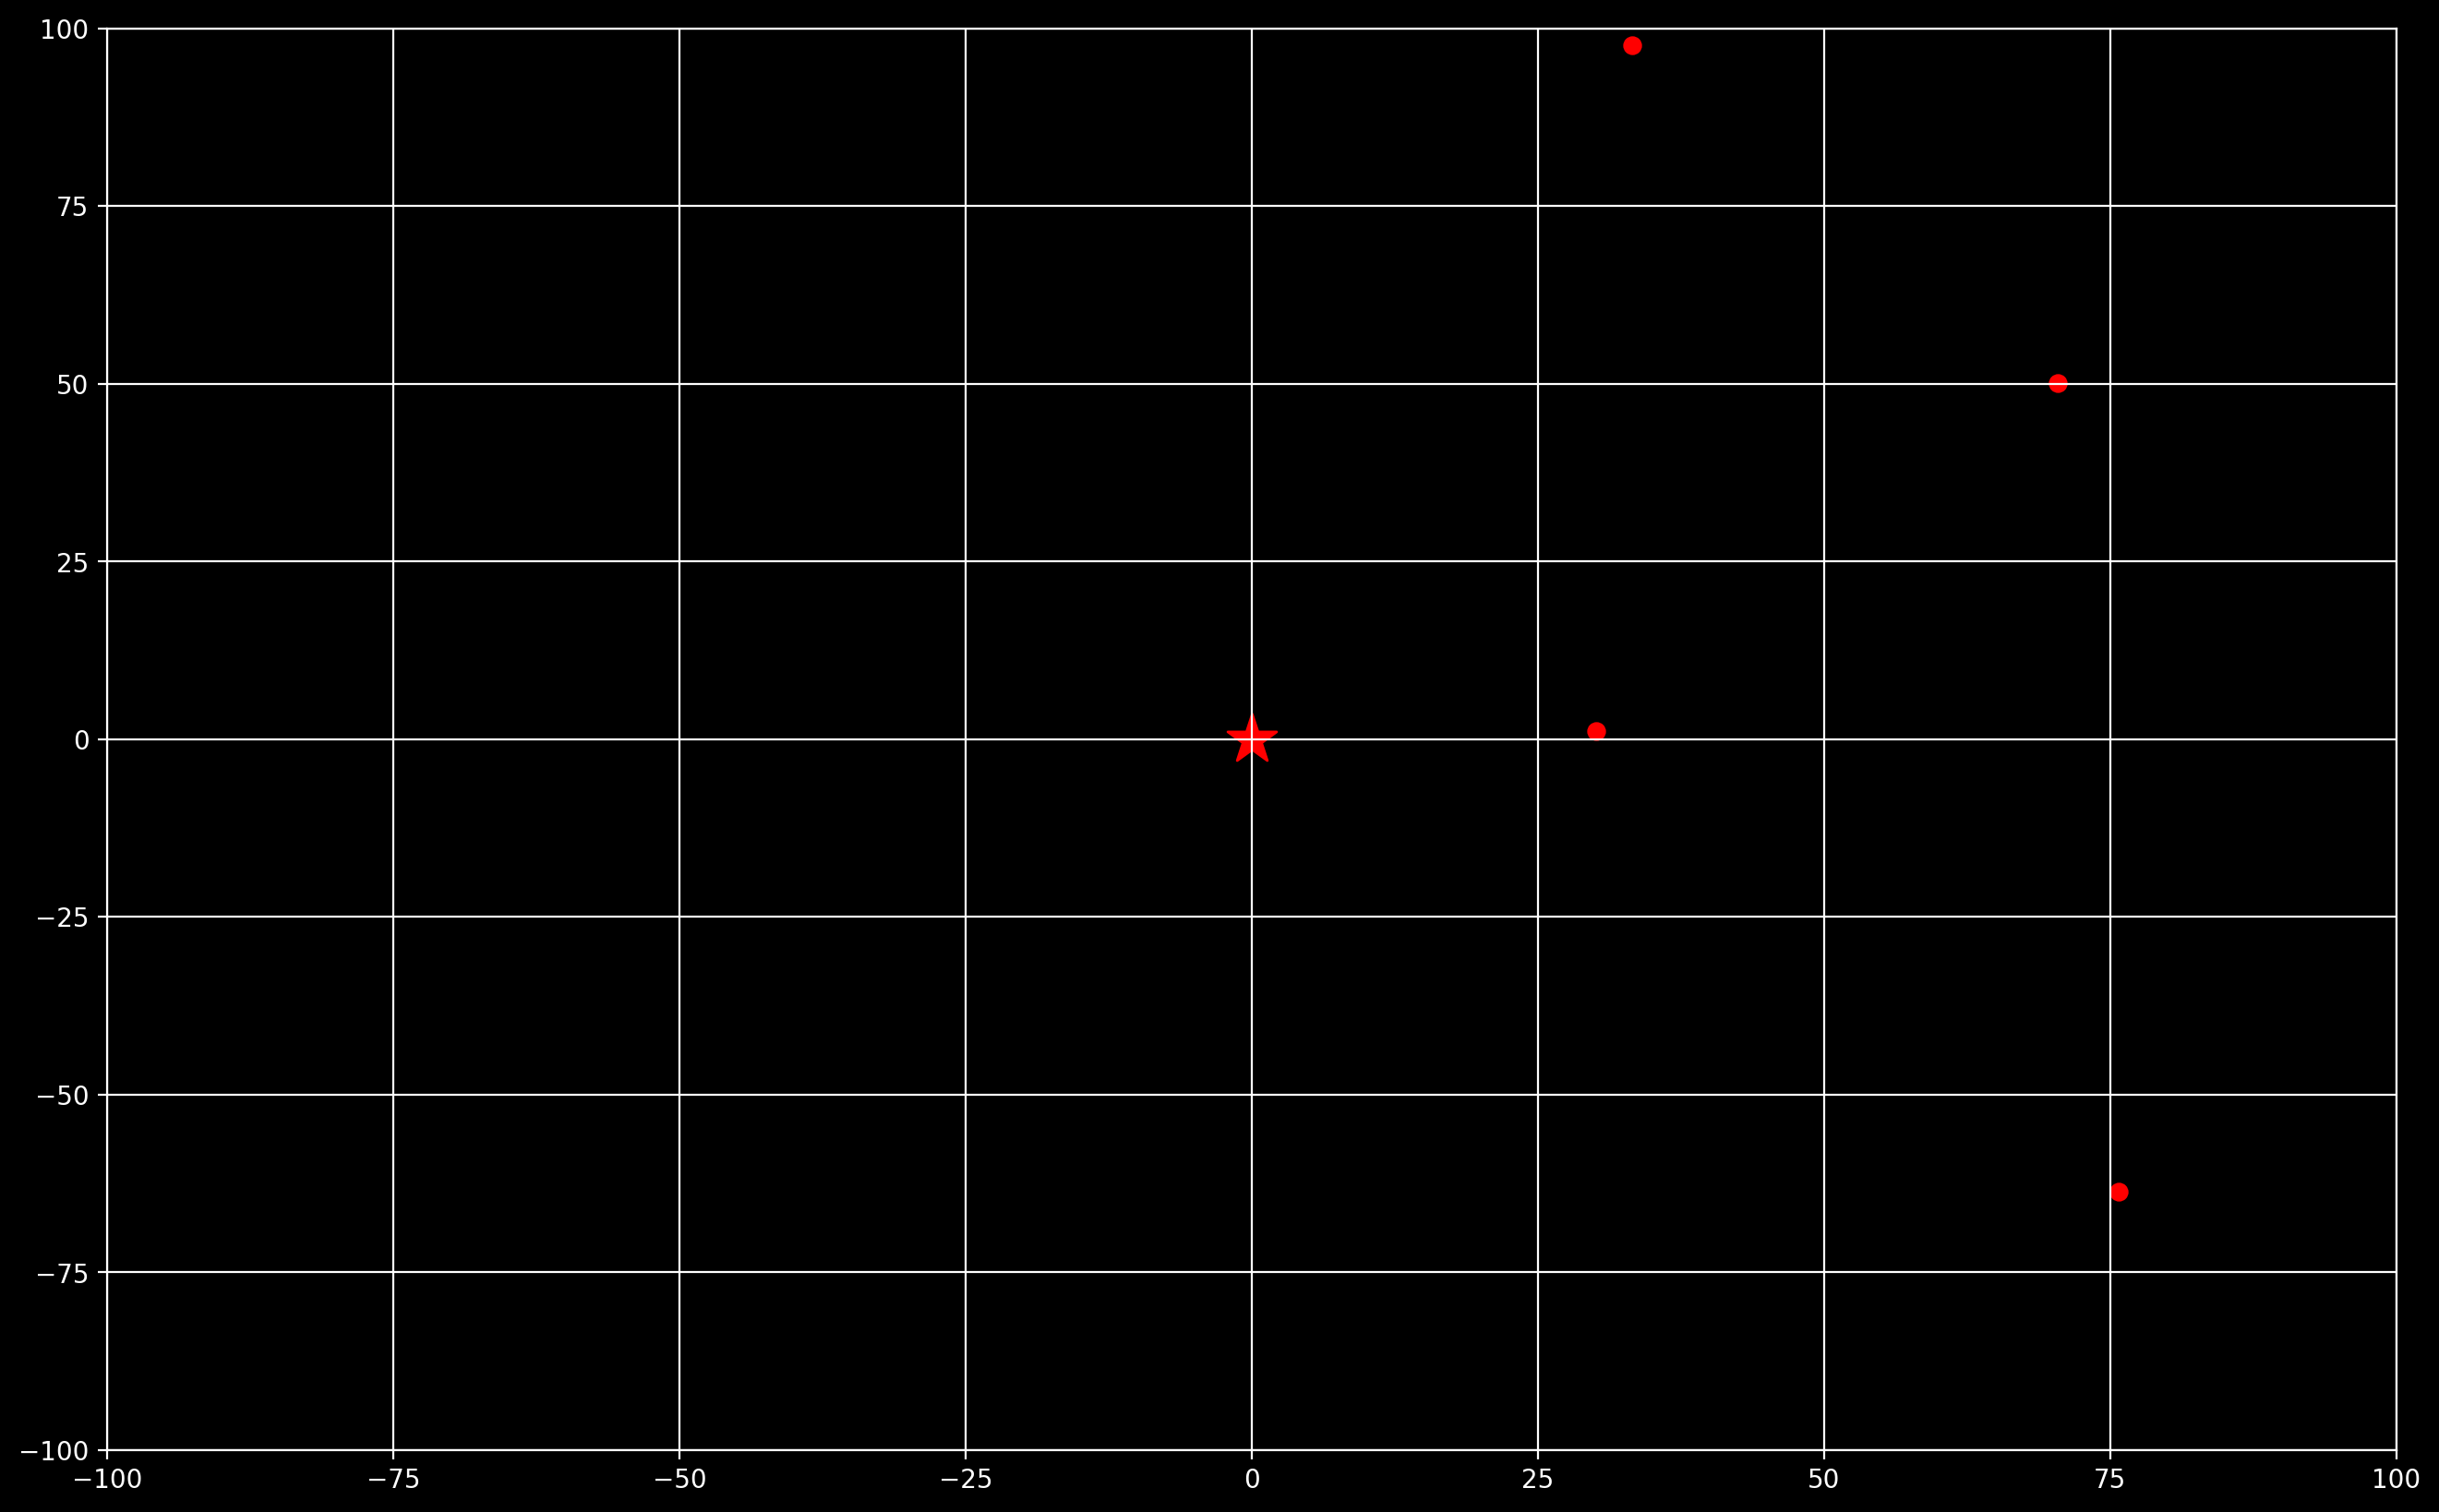

In [ ]:
plt.scatter(data.x, data.y, c='r', marker='o', s=40)
plt.scatter(data.iloc[0].x, data.iloc[0].y, marker='*', c='r', s=400)
plt.axis([-100,100,-100,100])
plt.grid(True)

In [ ]:
distance_func = lambda a,b: np.sqrt((a.x-b.x)**2 + (a.y-b.y)**2)
def compute_distances(dfunc=distance_func):
    for i in range(size+1):
        current=data.iloc[i]
        data[i]=dfunc(current, data)
        #data[str(i)][i]=np.nan

%time compute_distances()
data

CPU times: user 7.82 ms, sys: 180 µs, total: 8 ms
Wall time: 10.4 ms


,x,y,0,1,2,3,4
0,0.000000,0.000000,0.000000,30.094619,98.906970,86.402846,103.078947
1,30.074848,1.090675,30.094619,0.000000,79.199277,63.440275,96.539672
2,75.720294,-63.631955,98.906970,79.199277,0.000000,113.781493,166.719068
3,70.446614,50.027257,86.402846,63.440275,113.781493,0.000000,60.390171
4,33.220333,97.579090,103.078947,96.539672,166.719068,60.390171,0.000000


In [ ]:
estimate_cost = lambda route: sum(data.iloc[i][j] for i,j in zip(route, route[1:]))
get_coords = lambda route: list(zip(*[(data.iloc[i].x,data.iloc[i].y) for i in route]))

### Method 1: Nearest Neighbor heuristic (without 2-opt)

In [ ]:
def nearest_neighbor(unserved, stop_condition=lambda route, target: False):
    current=0 #depot
    result_path=[]
    while True:
        result_path.append(current)
        unserved.remove(current)
        if not unserved:
            break

        current=data.iloc[unserved,current+2].idxmin()
        if stop_condition(result_path, int(current)):
            if len(result_path)>1:
                break

    result_path.append(0)
    return result_path

%time route = nearest_neighbor(list(range(size+1)))
print('cost={}\nroute={}'.format(estimate_cost(route),route))

CPU times: user 1.5 ms, sys: 0 ns, total: 1.5 ms
Wall time: 1.42 ms
cost=419.5511021116068
route=[0, 1, 3, 4, 2, 0]


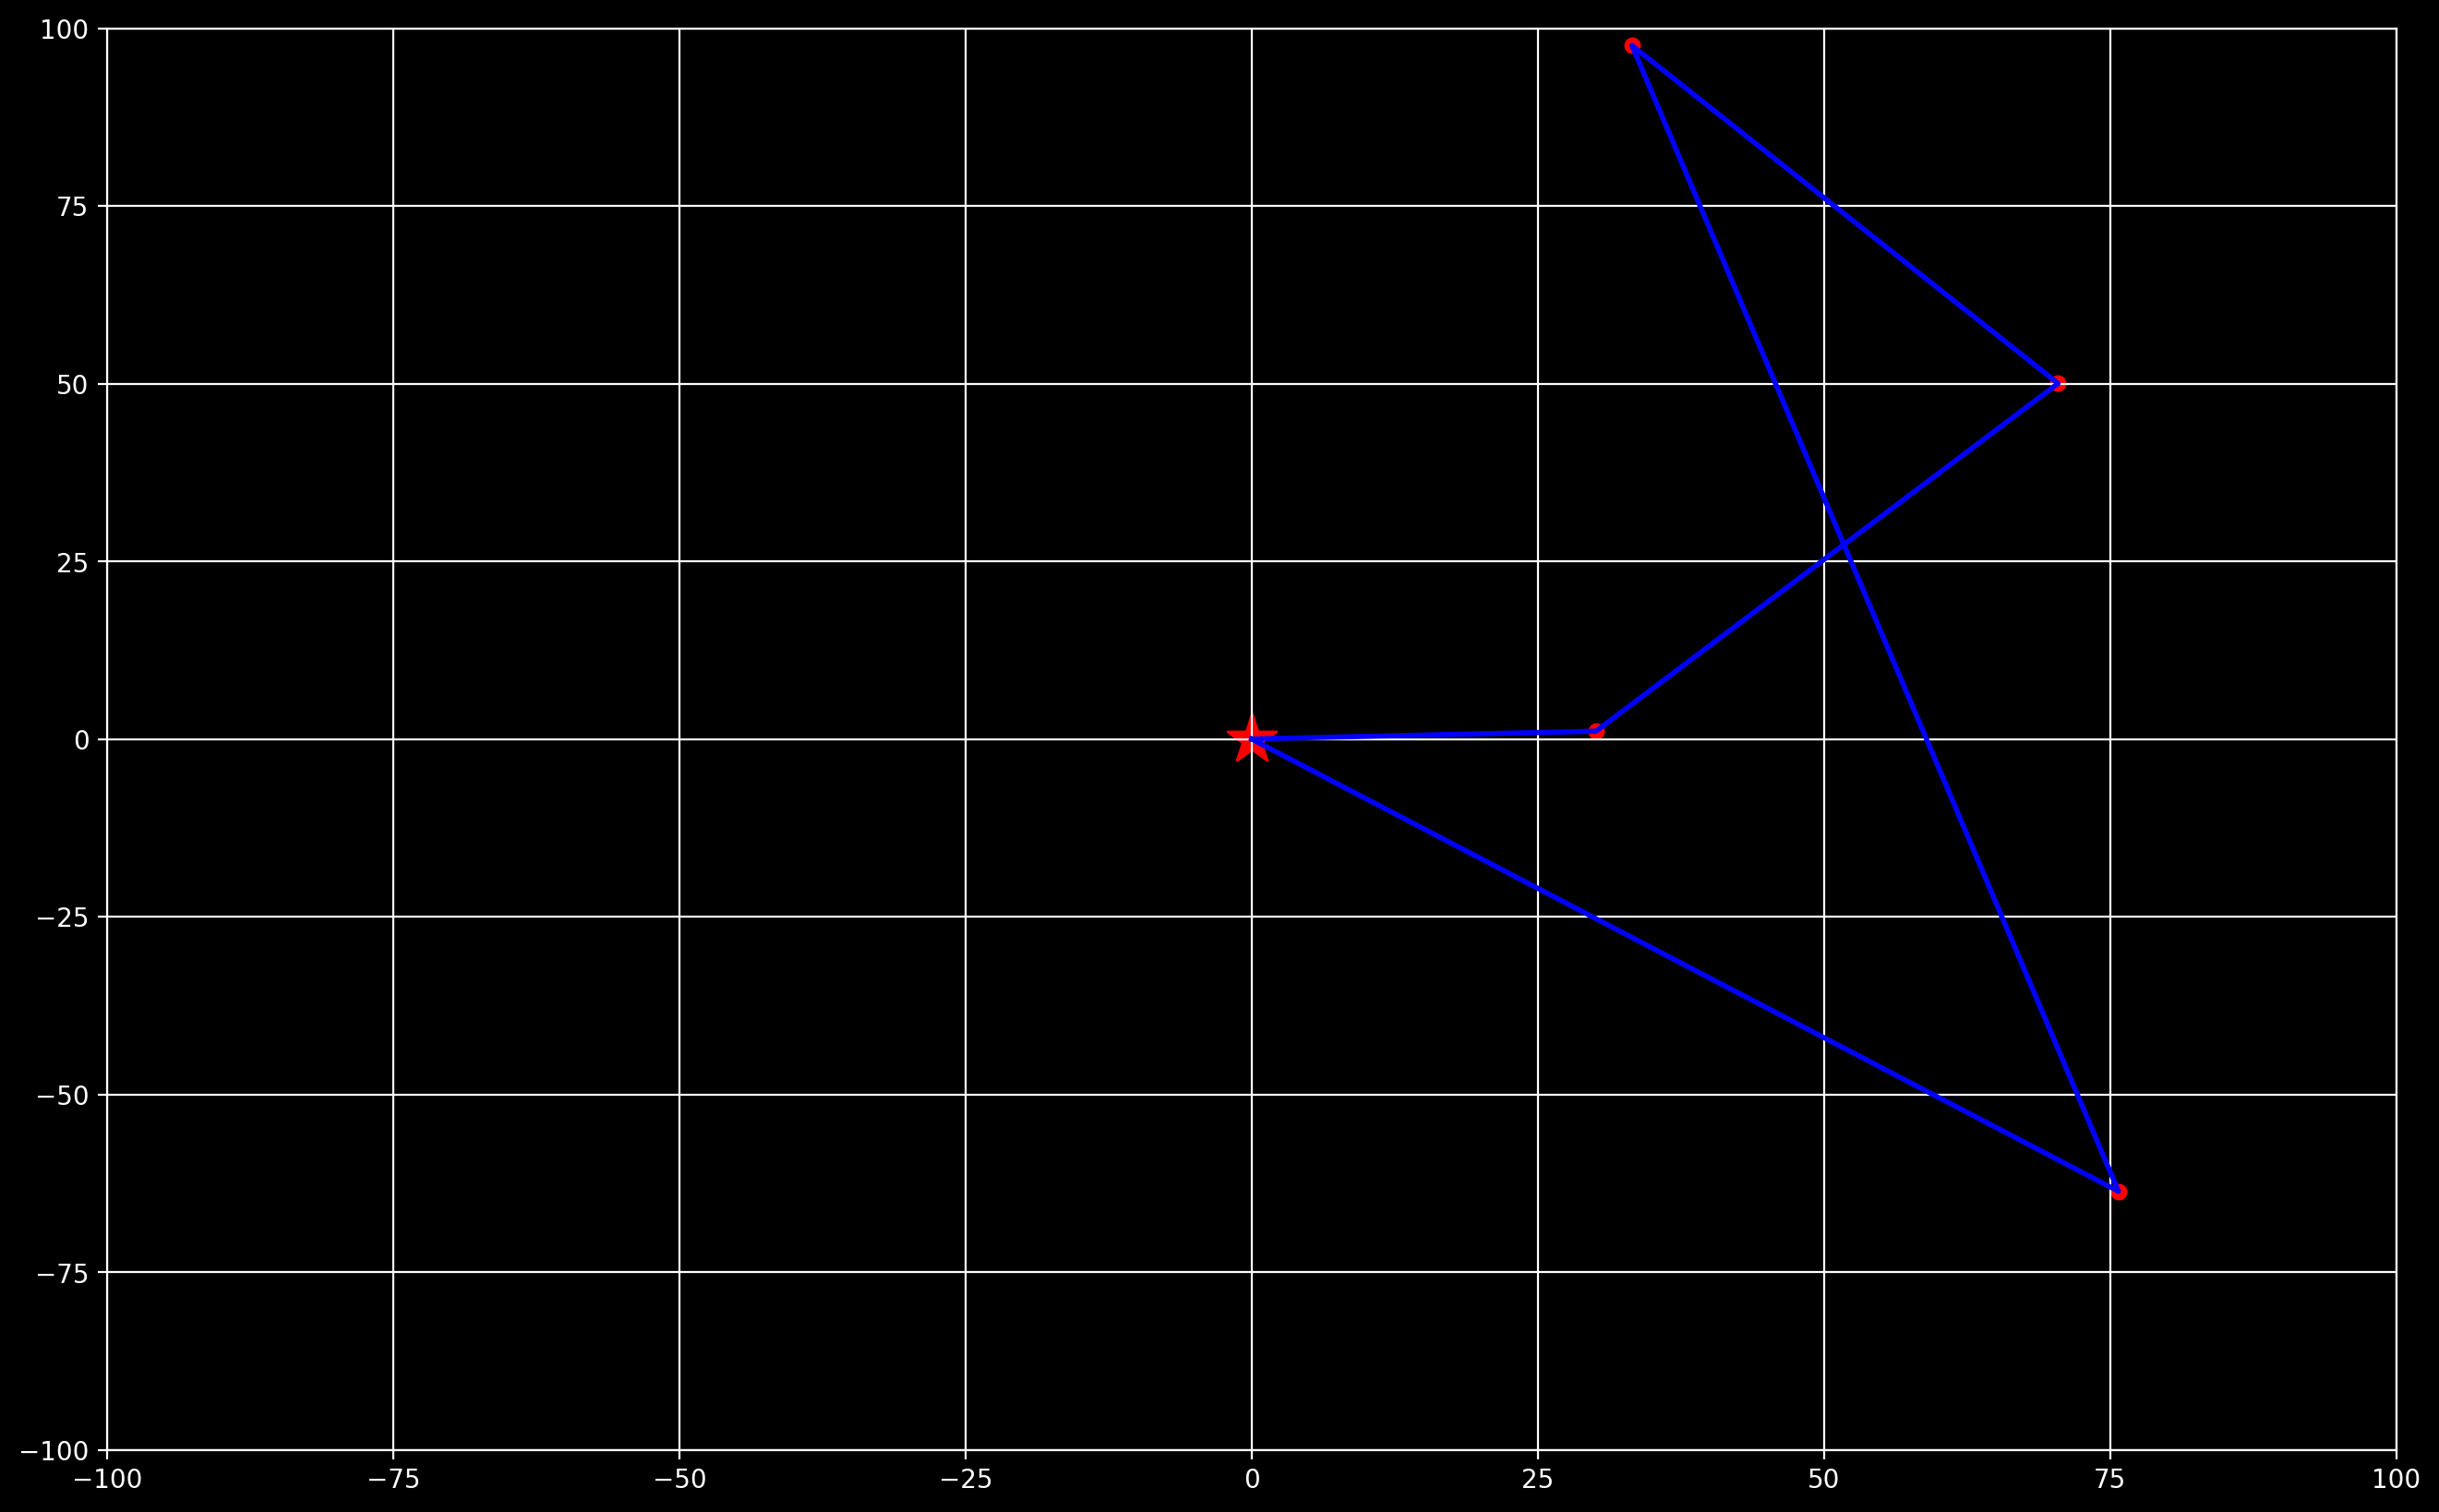

In [ ]:
coords=get_coords(route)
plt.plot(coords[0], coords[1], 'b-', linewidth=2)
plt.scatter(data.x, data.y, c='r', s=30)
plt.scatter(data.iloc[0].x, data.iloc[0].y, marker='*', c='r', s=400)
plt.axis([-100,100,-100,100])
plt.grid(True)

### Method 2: Nearest Neighbor heuristic (with 2-opt)

In [ ]:
def twoOptSwap(route,i,j):
    t=route[i:j+1];
    t.reverse();
    route[i:j+1]=t

def twoOpt(route):
    cost=estimate_cost(route)

    def inner():
        nonlocal cost
        for i in range(1,len(route)-2):
            nodei=data.iloc[route[i]]
            for j in range(i+1,len(route)-1):
                nodej=data.iloc[route[j]]
                save=nodei.iloc[route[i-1]+2]+nodej.iloc[route[j+1]+2] - (nodej.iloc[route[i-1]+2]+nodei.iloc[route[j+1]+2])
                if save>0:
                    twoOptSwap(route,i,j)

                    cost-=save
                    print('exchanging {}-{},{}-{} with {}-{},{}-{} => save={} => cost: {}'.format(
                            route[i-1],route[i],route[j],route[j+1],route[i-1],route[j],route[i],route[j+1],save,cost))
                    return False
        return True

    while True:
        if inner():
            break

%time twoOpt(route)
print('cost={}\nroute={}'.format(estimate_cost(route),route))

exchanging 0-4,1-2 with 0-1,4-2 => save=14.535462292800162 => cost: 405.0156398188066
exchanging 3-2,1-0 with 3-1,2-0 => save=18.47113306278979 => cost: 386.54450675601686
CPU times: user 4.24 ms, sys: 58 µs, total: 4.3 ms
Wall time: 4.56 ms
cost=386.54450675601686
route=[0, 4, 3, 2, 1, 0]


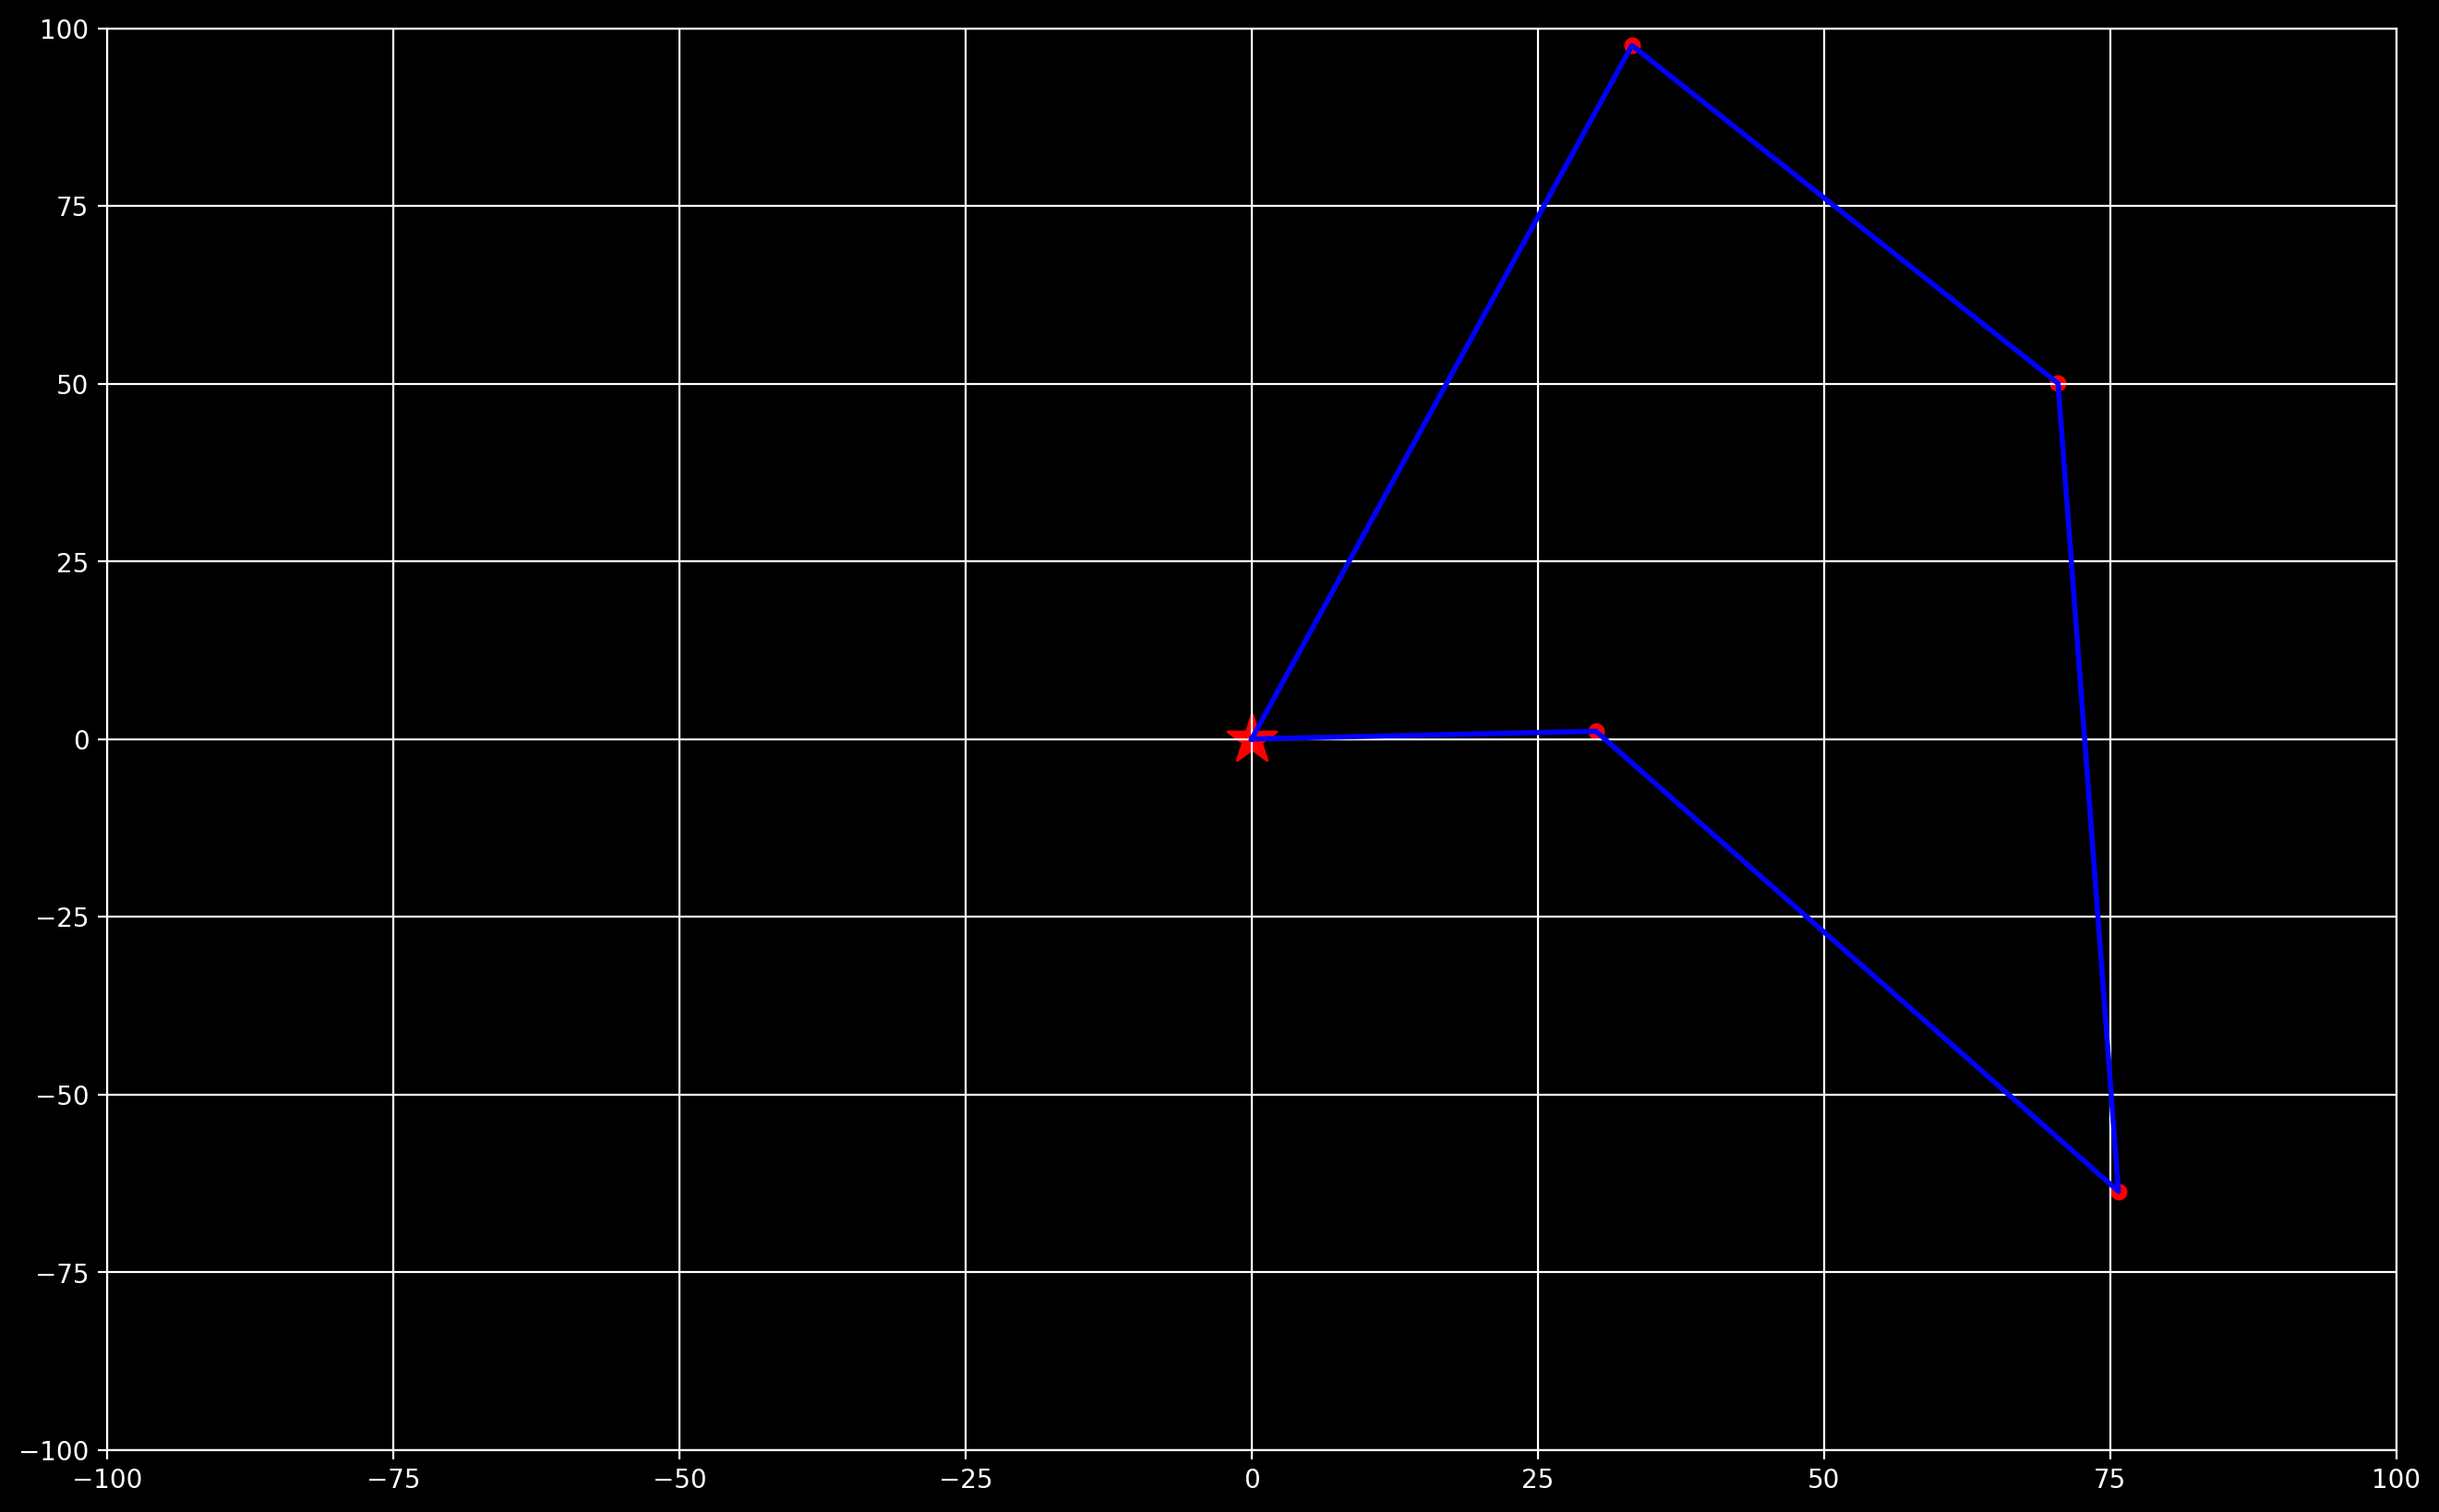

In [ ]:
coords=get_coords(route)
plt.plot(coords[0], coords[1], 'b-', linewidth=2)
plt.scatter(data.x, data.y, c='r', s=30)
plt.scatter(data.iloc[0].x, data.iloc[0].y, marker='*', c='r', s=400)
plt.axis([-100,100,-100,100])
plt.grid(True)

### Method 3: center depot, one van, randomized nearest neighbour heuristic (with 2-opt)

Randomized route without NN applied on it yet

In [ ]:
route = [x for x in range(size+1)]+[0]
print('cost={}\nroute={}'.format(estimate_cost(route),route))

cost=386.54450675601686
route=[0, 1, 2, 3, 4, 0]


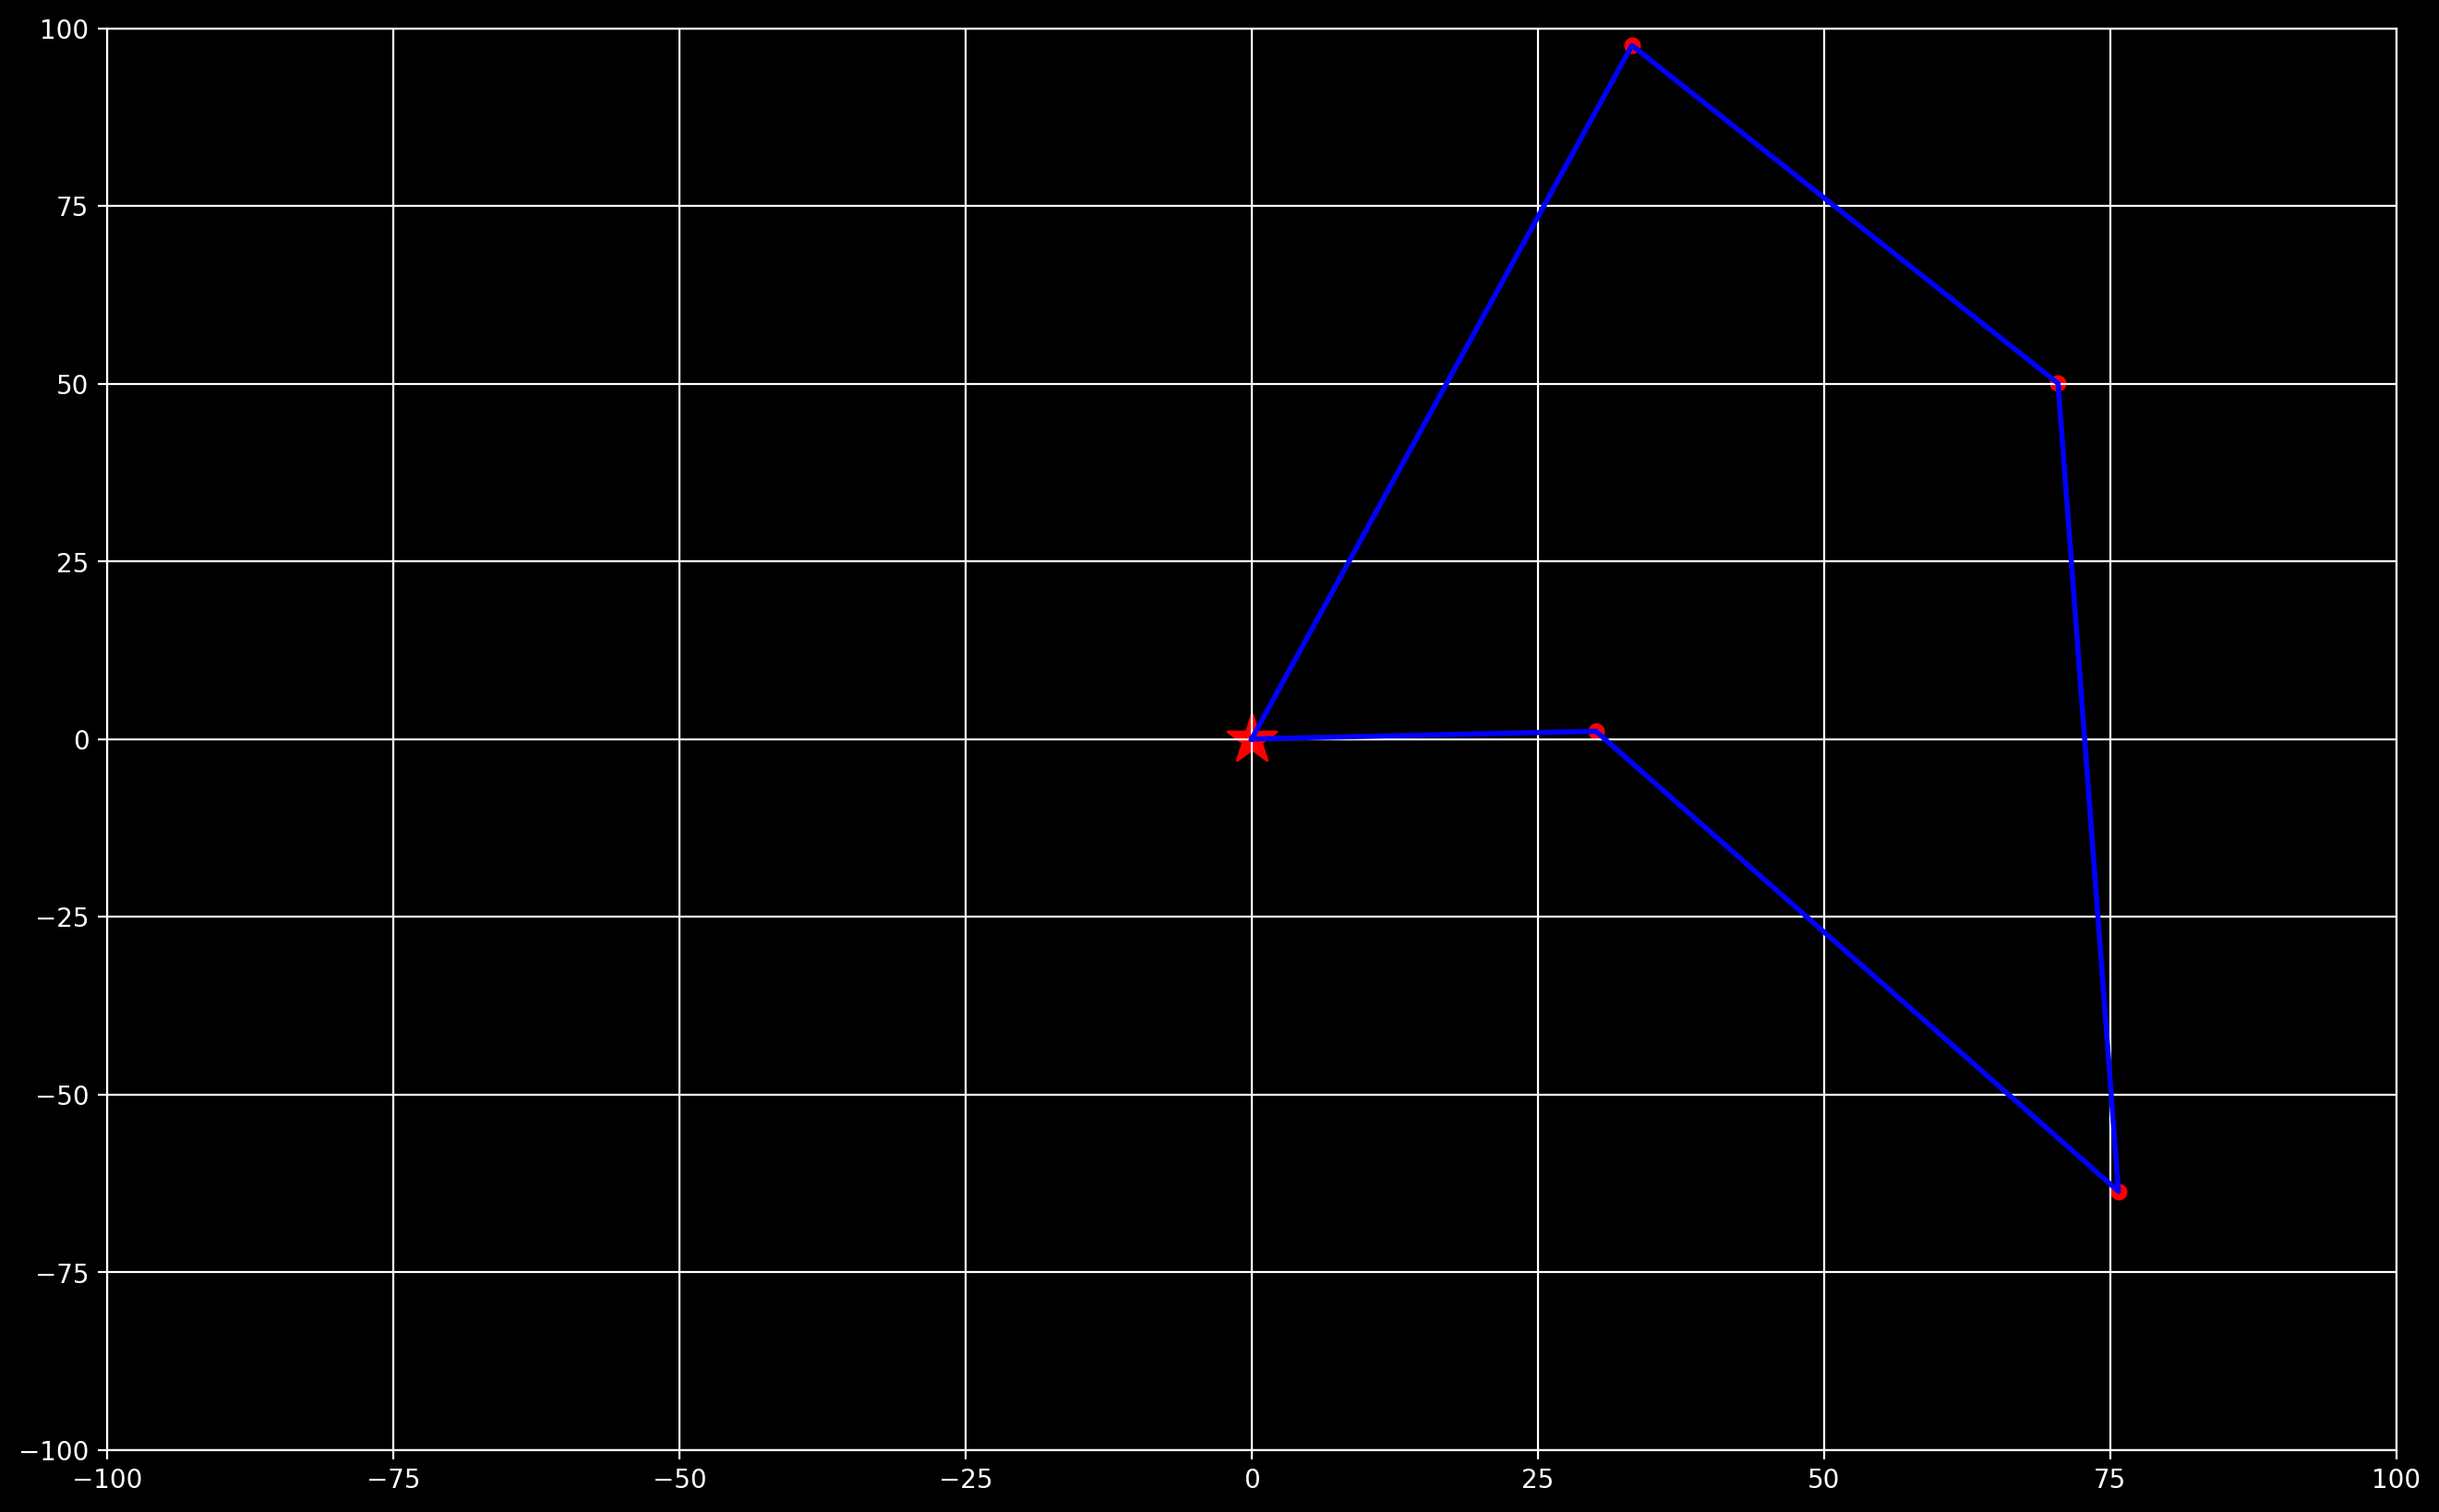

In [ ]:
coords=get_coords(route)
plt.plot(coords[0], coords[1], 'b-', linewidth=2)
plt.scatter(data.x, data.y, c='r', s=30)
plt.scatter(data.iloc[0].x, data.iloc[0].y, marker='*', c='r', s=400)
plt.axis([-100,100,-100,100])
plt.grid(True)

In [ ]:
%time twoOpt(route)
print('cost={}'.format(estimate_cost(route)))

CPU times: user 1.57 ms, sys: 0 ns, total: 1.57 ms
Wall time: 1.57 ms
cost=386.54450675601686


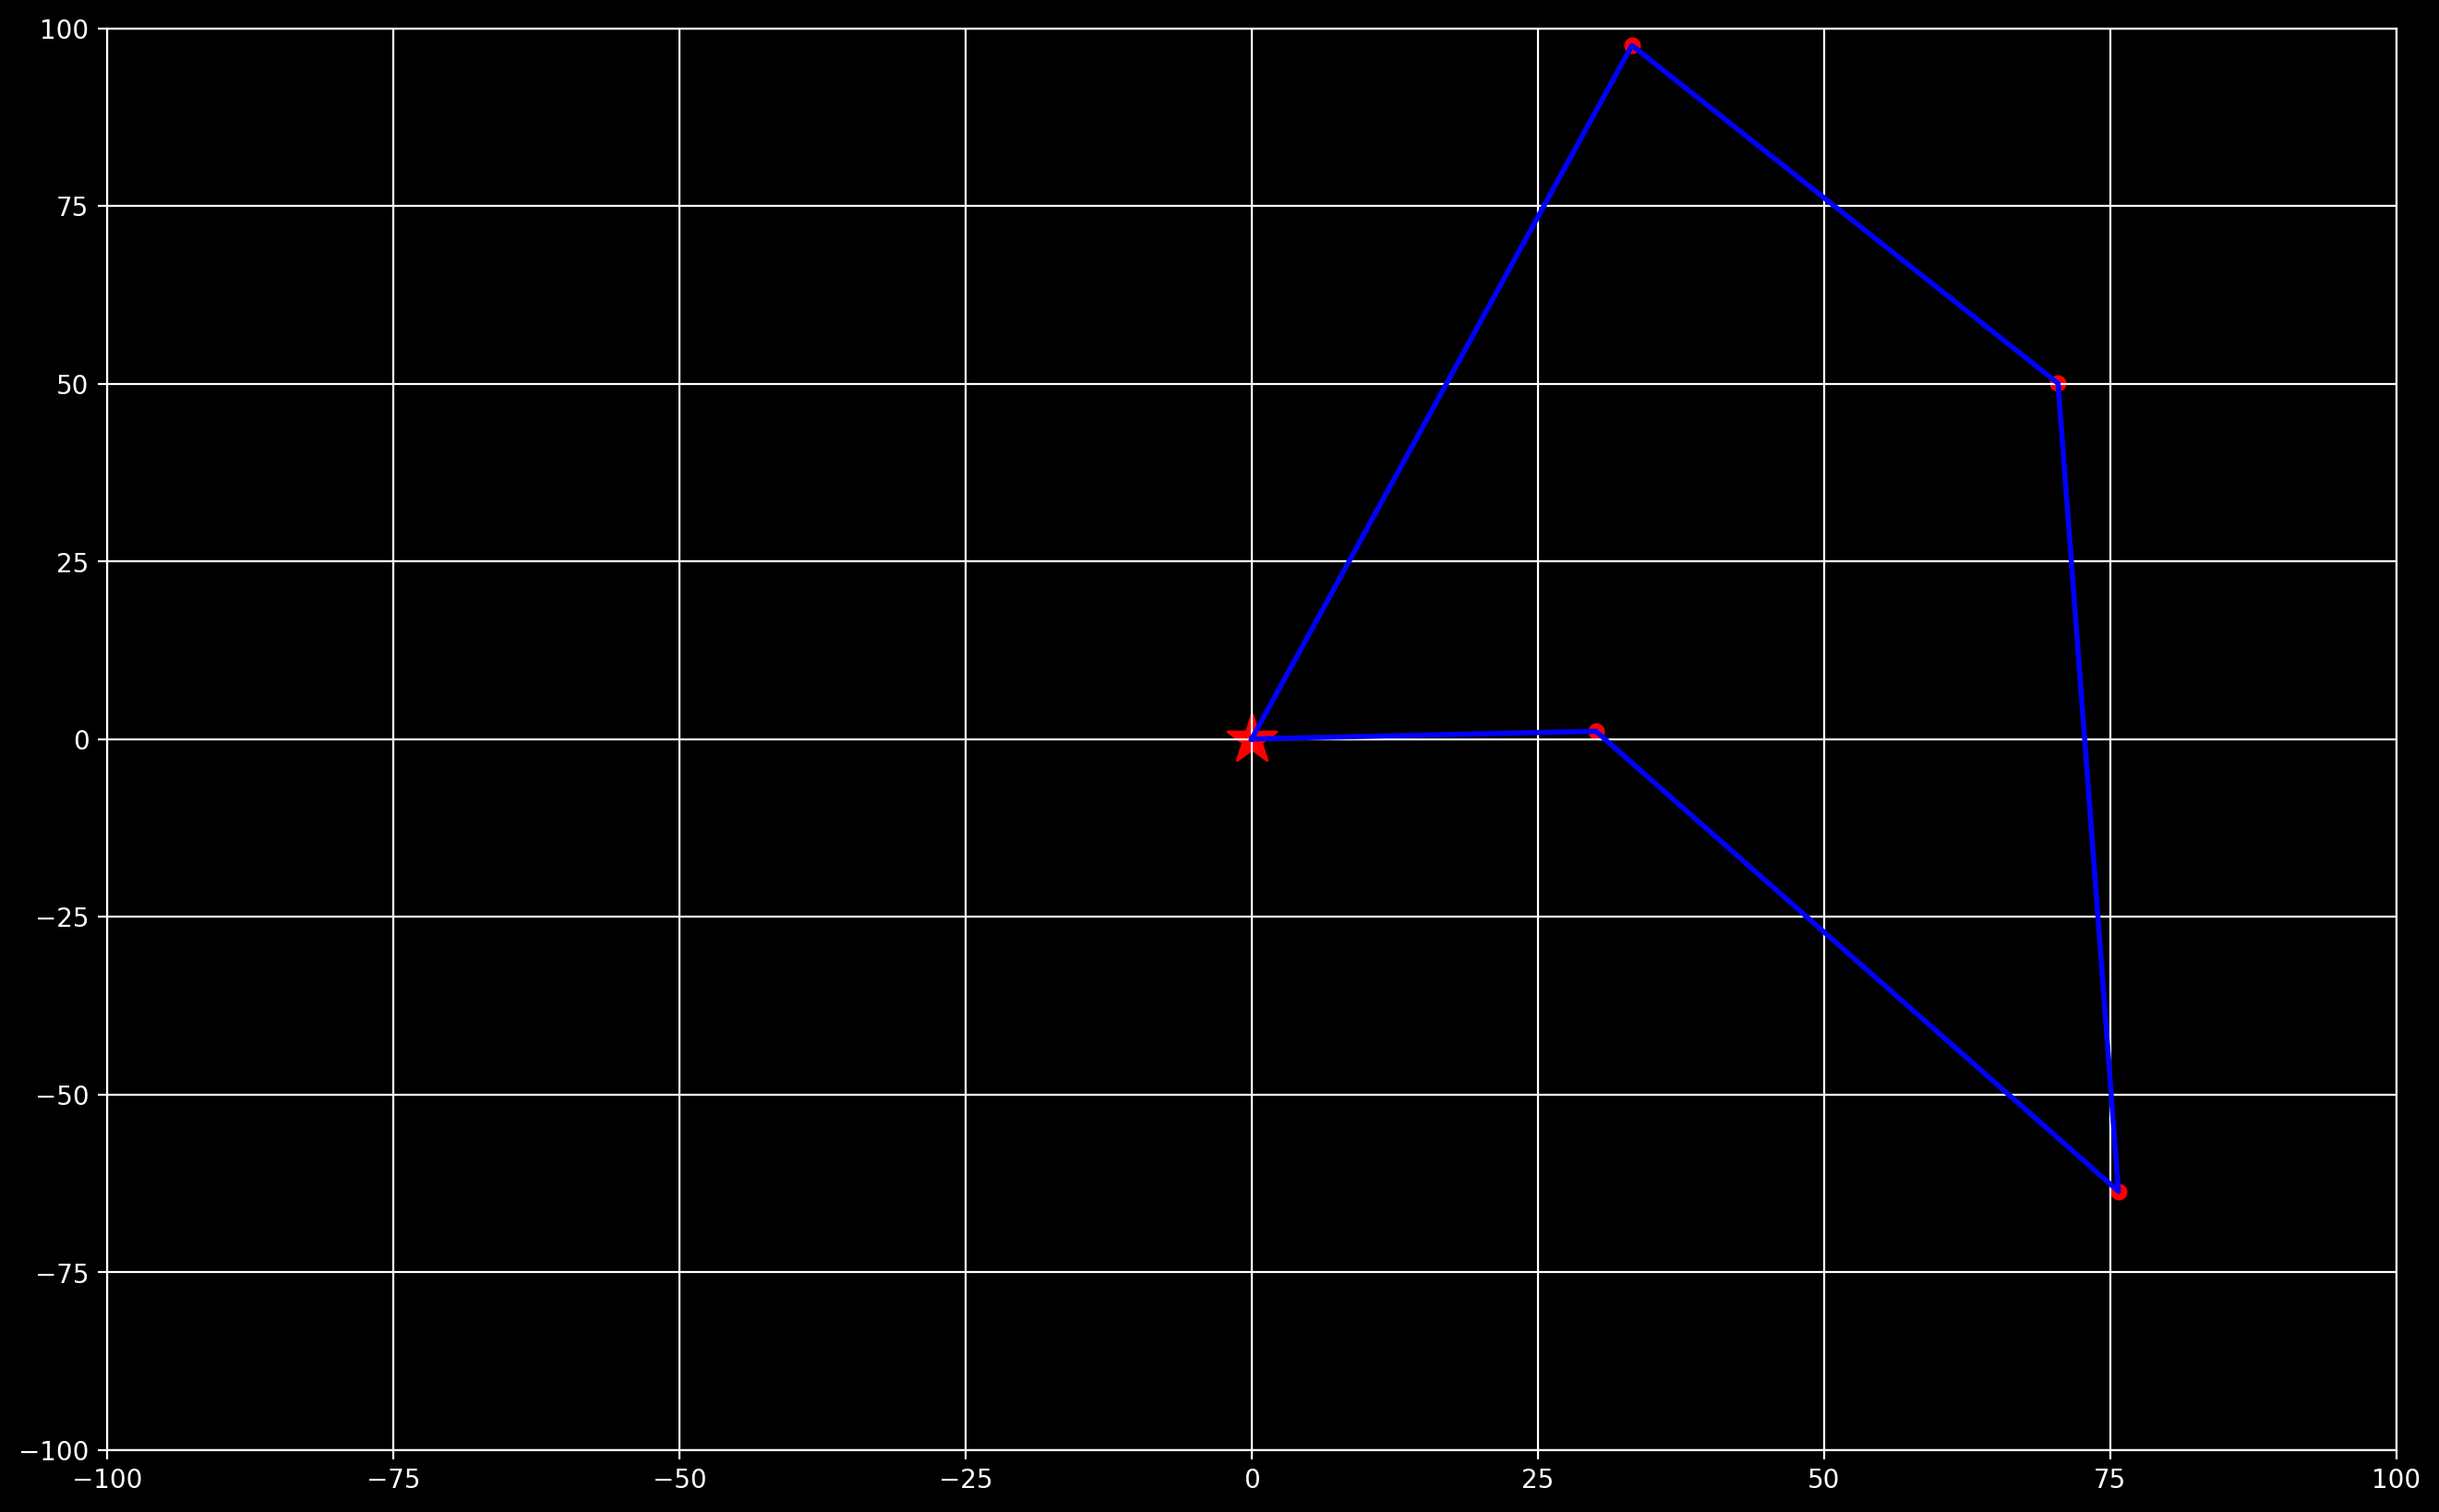

In [ ]:
coords=get_coords(route)
plt.plot(coords[0], coords[1], 'b-', linewidth=2)
plt.scatter(data.x, data.y, c='r', s=30)
plt.scatter(data.iloc[0].x, data.iloc[0].y, marker='*', c='r', s=400)
plt.axis([-100,100,-100,100])
plt.grid(True)

###Method 4: Christofides algorithm

In [ ]:
def tsp(data):
    # build a graph
    G = build_graph(data)
    # print("Graph: ", G)

    # build a minimum spanning tree
    MSTree = minimum_spanning_tree(G)
    # print("MSTree: ", MSTree)

    # find odd vertexes
    odd_vertexes = find_odd_vertexes(MSTree)
    # print("Odd vertexes in MSTree: ", odd_vertexes)

    # add minimum weight matching edges to MST
    minimum_weight_matching(MSTree, G, odd_vertexes)
    # print("Minimum weight matching: ", MSTree)

    # find an eulerian tour
    eulerian_tour = find_eulerian_tour(MSTree, G)

    # print("Eulerian tour: ", eulerian_tour)

    current = eulerian_tour[0]
    path = [current]
    visited = [False] * len(eulerian_tour)
    visited[eulerian_tour[0]] = True
    length = 0

    for v in eulerian_tour:
        if not visited[v]:
            path.append(v)
            visited[v] = True

            length += G[current][v]
            current = v

    length +=G[current][eulerian_tour[0]]
    path.append(eulerian_tour[0])

    # print("Result path: ", path)
    # print("Result length of the path: ", length)

    return length, path


def get_length(x1, y1, x2, y2):
    return ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** (1.0 / 2.0)


def build_graph(data):
    graph = {}
    for this in range(len(data)):
        for another_point in range(len(data)):
            if this != another_point:
                if this not in graph:
                    graph[this] = {}

                graph[this][another_point] = get_length(data[this][0], data[this][1], data[another_point][0],
                                                        data[another_point][1])

    return graph


class UnionFind:
    def __init__(self):
        self.weights = {}
        self.parents = {}

    def __getitem__(self, object):
        if object not in self.parents:
            self.parents[object] = object
            self.weights[object] = 1
            return object

        # find path of objects leading to the root
        path = [object]
        root = self.parents[object]
        while root != path[-1]:
            path.append(root)
            root = self.parents[root]

        # compress the path and return
        for ancestor in path:
            self.parents[ancestor] = root
        return root

    def __iter__(self):
        return iter(self.parents)

    def union(self, *objects):
        roots = [self[x] for x in objects]
        heaviest = max([(self.weights[r], r) for r in roots])[1]
        for r in roots:
            if r != heaviest:
                self.weights[heaviest] += self.weights[r]
                self.parents[r] = heaviest


def minimum_spanning_tree(G):
    tree = []
    subtrees = UnionFind()
    for W, u, v in sorted((G[u][v], u, v) for u in G for v in G[u]):
        if subtrees[u] != subtrees[v]:
            tree.append((u, v, W))
            subtrees.union(u, v)

    return tree


def find_odd_vertexes(MST):
    tmp_g = {}
    vertexes = []
    for edge in MST:
        if edge[0] not in tmp_g:
            tmp_g[edge[0]] = 0

        if edge[1] not in tmp_g:
            tmp_g[edge[1]] = 0

        tmp_g[edge[0]] += 1
        tmp_g[edge[1]] += 1

    for vertex in tmp_g:
        if tmp_g[vertex] % 2 == 1:
            vertexes.append(vertex)

    return vertexes


def minimum_weight_matching(MST, G, odd_vert):
    import random
    random.shuffle(odd_vert)

    while odd_vert:
        v = odd_vert.pop()
        length = float("inf")
        u = 1
        closest = 0
        for u in odd_vert:
            if v != u and G[v][u] < length:
                length = G[v][u]
                closest = u

        MST.append((v, closest, length))
        odd_vert.remove(closest)


def find_eulerian_tour(MatchedMSTree, G):
    # find neigbours
    neighbours = {}
    for edge in MatchedMSTree:
        if edge[0] not in neighbours:
            neighbours[edge[0]] = []

        if edge[1] not in neighbours:
            neighbours[edge[1]] = []

        neighbours[edge[0]].append(edge[1])
        neighbours[edge[1]].append(edge[0])

    # print("Neighbours: ", neighbours)

    # finds the hamiltonian circuit
    start_vertex = MatchedMSTree[0][0]
    EP = [neighbours[start_vertex][0]]

    while len(MatchedMSTree) > 0:
        for i, v in enumerate(EP):
            if len(neighbours[v]) > 0:
                break

        while len(neighbours[v]) > 0:
            w = neighbours[v][0]

            remove_edge_from_matchedMST(MatchedMSTree, v, w)

            del neighbours[v][(neighbours[v].index(w))]
            del neighbours[w][(neighbours[w].index(v))]

            i += 1
            EP.insert(i, w)

            v = w

    return EP


def remove_edge_from_matchedMST(MatchedMST, v1, v2):

    for i, item in enumerate(MatchedMST):
        if (item[0] == v2 and item[1] == v1) or (item[0] == v1 and item[1] == v2):
            del MatchedMST[i]

    return MatchedMST


%time length, path= tsp(data2)
print("Cost: ",length)


CPU times: user 91 µs, sys: 19 µs, total: 110 µs
Wall time: 113 µs
Cost:  399.71292430930805


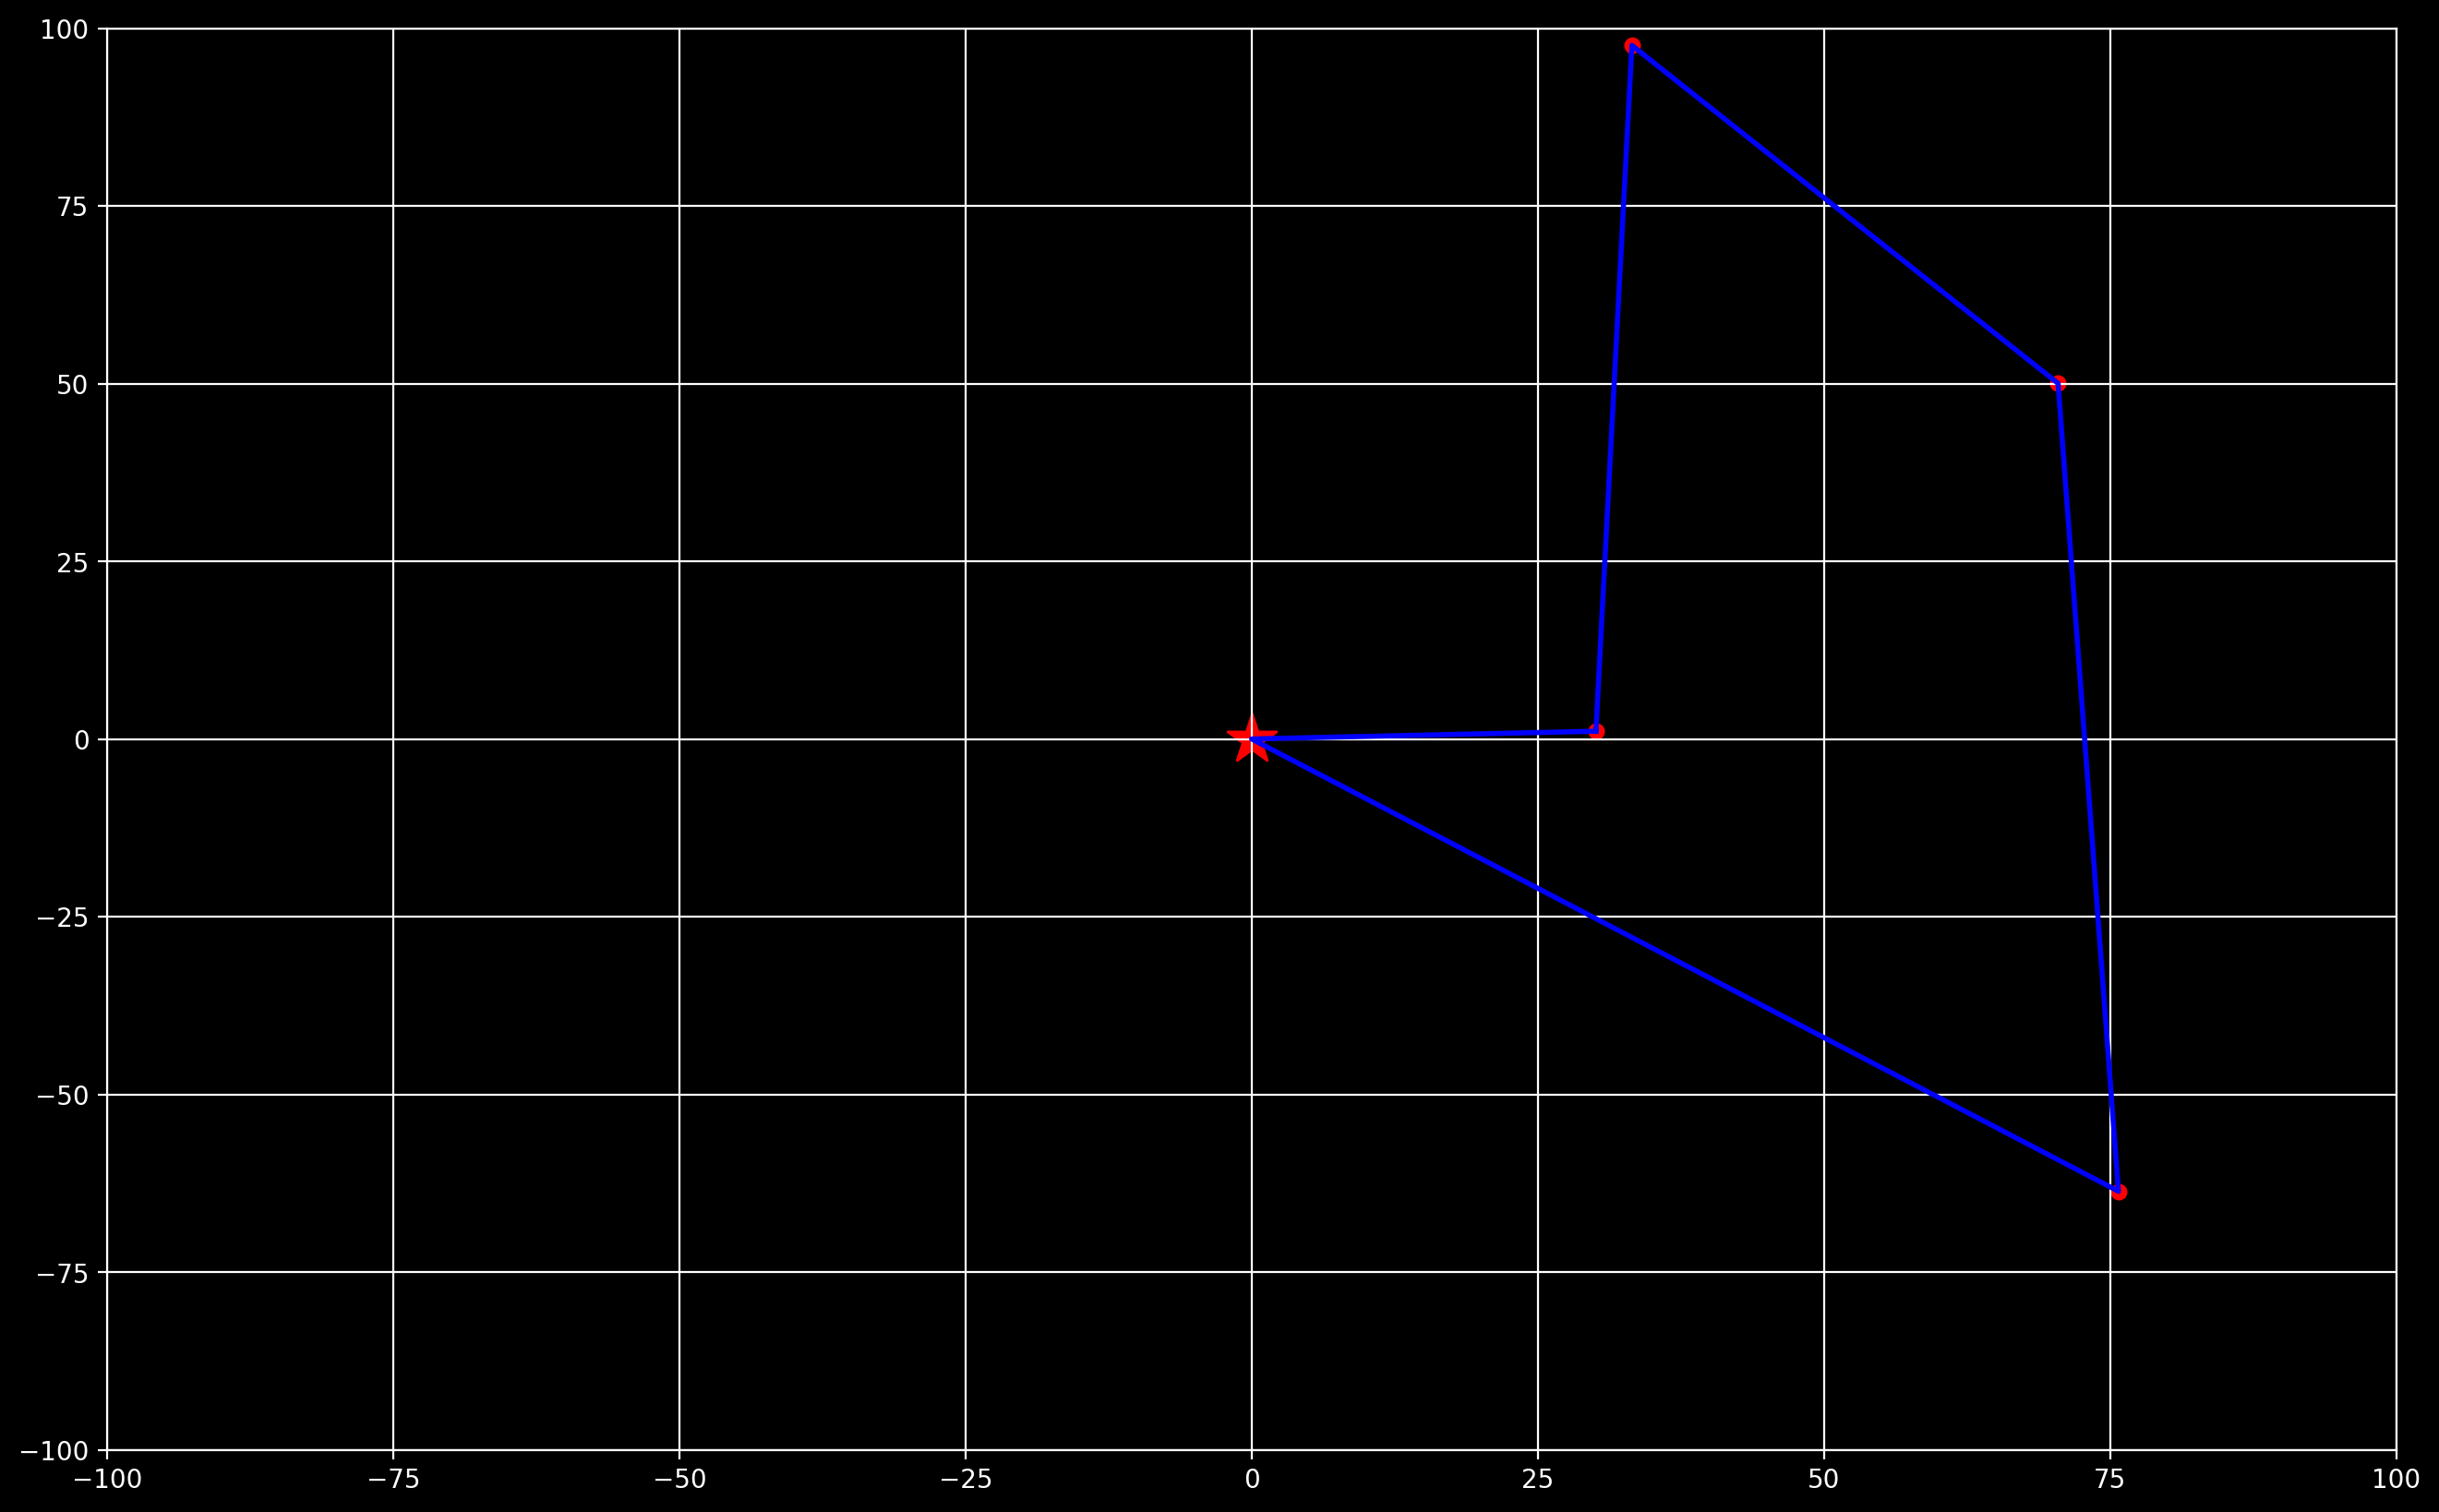

In [ ]:
coords=get_coords(path)
plt.plot(coords[0], coords[1], 'b-', linewidth=2)
plt.scatter(data.x, data.y, c='r', s=30)
plt.scatter(data.iloc[0].x, data.iloc[0].y, marker='*', c='r', s=400)
plt.axis([-100,100,-100,100])
plt.grid(True)

<table>
<tr>
<th>Method</th>
<th>Cost</th>
<th>Time</th>
</tr>
<tr>
<td>Nearest Neighbor heuristic(without 2-opt)</td>
<td>419.5511021116068</td>
<td>1.42 ms</td>
</tr>
<tr>
<td>Nearest Neighbor heuristic(with 2-opt)</td>
<td>386.54450675601686</td>
<td>4.56 ms</td>
</tr>
<tr>
<td>Randomized route (with 2-opt)</td>
<td>386.54450675601686</td>
<td>1.57 ms</td>
</tr>
<td>Christofides</td>
<td>399.71292430930805</td>
<td>113 µs</td>
</tr>
</table>

Obviously nearest neighbor heuristic(with 2-opt) is the best of these methods, both in terms of finding the least cost(distance) and time.